In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from datetime import timedelta
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

In [ ]:
CURRENT_LOCATION = "bolz"

In [ ]:
path_to_file = 'APPA_data_merged.csv'
df = pd.read_csv(path_to_file, parse_dates=["Data"])
df = df[df.Stazione == "Via Bolzano"]
df = df[df.Inquinante == "PM10"]

Makes the daily mean from the hour values

In [ ]:

df_daily = df.resample("D", on='Data').mean()
df_daily = df_daily.reset_index()

In [ ]:
df_daily.head()

In [ ]:
weather_file_path = "weather_data.csv"
weather_df = pd.read_csv(weather_file_path, parse_dates=["Data"])

In [ ]:
locations = list(set(weather_df.columns[1:].map(lambda x: x.split()[0])))
locations

In [ ]:
weather_loc = {}

for location in locations:
    location_columns = weather_df.columns[
        weather_df.columns.map(lambda x: x.split()[0] == location)
    ]

    location_df = weather_df[["Data"] + location_columns.tolist()]
    location_df.columns = location_df.columns.str.replace(location, "").str.strip()
    location_df["Location"] = location
    
    weather_loc[location] = location_df


In [ ]:
df_weather_long = pd.concat(weather_loc.values())
# df_weather_long.to_csv("./weather_long_format.csv", index=None)

In [ ]:
merged_df = df_daily.join(
    df_weather_long[df_weather_long.Location == CURRENT_LOCATION].set_index("Data"), 
    on="Data"
)
merged_df

In [ ]:
# add column for the value of the previous day

prev_day_values = []
for date in merged_df["Data"]:
    prev_day_value = date - timedelta(hours=int(24))
    series = merged_df[merged_df.Data == prev_day_value].Valore.values.tolist()
    if len(series) > 0:
        value = series[0]
    else:
        value = merged_df[merged_df.Data == date].Valore.values.tolist()[0]  # takes the current day, not the previous

    prev_day_values.append(value)

merged_df["Prev day"] = prev_day_values
merged_df


In [ ]:
merged_df.isna().sum()

In [ ]:
merged_df.corr()

In [ ]:
merged_df.describe()

In [ ]:
merged_df = merged_df.dropna()
merged_df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
SEED = 42

In [ ]:
input_columns = [
    'rain', 
    'temp', 
    'hum', 
    'w_dir', 
    'w_sp', 
    'press', 
    'sol',
    #'Prev day'
]

y = merged_df['Valore']
X = merged_df[input_columns]

In [ ]:
test_years = [2015, 2017]
train_years = [2012, 2013, 2014, 2016, 2018, 2019, 2020, 2021, 2022]


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=SEED)

In [ ]:
X_train, y_train, X_test, y_test = (
    X[merged_df.Data.dt.year.isin(train_years)],
    y[merged_df.Data.dt.year.isin(train_years)],
    X[merged_df.Data.dt.year.isin(test_years)],
    y[merged_df.Data.dt.year.isin(test_years)]
)

In [ ]:
X.shape

# ---- Start of Linear regression ----

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
regressor.intercept_

In [ ]:
regressor.coef_

In [ ]:
feature_names = X.columns
model_coefficients = regressor.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient value'])
print(coefficients_df)

In [ ]:
feature_names = X.columns
model_coefficients = regressor.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient value'])
print(coefficients_df)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
X_test

In [ ]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

In [ ]:
results.corr()

In [ ]:
test_chart_data = merged_df[
    merged_df.Data.dt.year.isin(test_years)
]

In [ ]:
test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])

In [ ]:
input_columns

In [ ]:
prev_val = test_chart_data.iloc[-100].Valore
predictions = [0 for i in range(100)]
for i, row in test_chart_data.iloc[-100:].iterrows():
    row_array = row[input_columns].to_numpy()


    row_array[4]+=10


    row_array[-1] = prev_val
    result = regressor.predict([row_array])[0]
    prev = result
    predictions.append(result)

In [ ]:
regressor.predict([list(range(0,8))])

In [ ]:
plt.plot(predictions, label ="pred")
plt.plot(test_chart_data.iloc[-100:].Valore.to_numpy(), label="true")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
test_chart_data.plot("Data", "Valore", ax=ax)
test_chart_data.plot("Data", "pred", ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
test_chart_data.plot.scatter("Valore", "pred", alpha=0.3, ax=ax)
# ax.set_xlim(-5, 165)
# ax.set_ylim(-5, 165)

ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)



In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

In [ ]:
regressor.score(X_test, y_test)

In [ ]:
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R²:', r2)

# ---- START OF RANDOM FOREST ----

In [ ]:
from sklearn.ensemble import RandomForestRegressor
SEED = 42


In [657]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = SEED)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [658]:
score = regressor.score(X_train, y_train)
print("R2:", score)

R2: 0.9301207647858298


In [659]:
y_pred = regressor.predict(X_test)

In [660]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

         Actual  Predicted
1096  67.600000  48.505453
1097  45.666667  41.461304
1098  43.125000  38.350377
1099  20.500000  23.558485
1100  38.416667  28.020779
...         ...        ...
2187  37.083333  30.606212
2188   7.291667  21.736954
2189  16.666667  23.337951
2190  26.291667  28.010686
2191  42.875000  51.945166

[725 rows x 2 columns]


In [661]:
results.corr()

,Actual,Predicted
Actual,1.000000,0.677465
Predicted,0.677465,1.000000


In [662]:
test_chart_data = merged_df[
    merged_df.Data.dt.year.isin(test_years)
]
test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\643691821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])


In [663]:
X_train

,rain,temp,hum,w_dir,w_sp,press,sol
0,0.0,0.0,78.6,342.0,0.7,995.5,6433.5
1,15.0,-0.4,95.0,348.0,1.0,994.7,1154.3
2,0.6,3.6,86.8,329.0,1.8,997.5,7082.0
3,0.0,0.1,90.0,337.0,1.0,993.7,3149.2
4,0.0,1.0,79.8,343.0,1.5,980.3,5839.9
...,...,...,...,...,...,...,...
3837,7.0,23.2,70.6,315.0,3.7,991.4,16440.8
3838,0.0,24.9,59.5,330.0,2.9,989.0,25228.8
3839,0.0,25.2,54.2,336.0,2.0,990.8,28751.0
3840,4.0,23.5,62.2,296.0,1.3,989.6,19994.8


<AxesSubplot:xlabel='Data'>

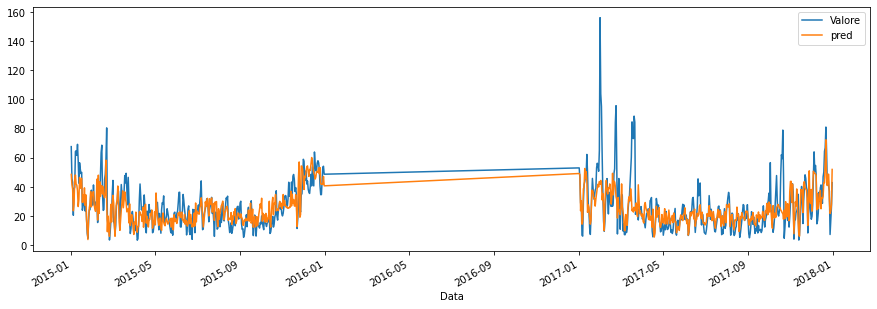

In [664]:
fig, ax = plt.subplots(figsize=(15, 5))
test_chart_data.plot("Data", "Valore", ax=ax)
test_chart_data.plot("Data", "pred", ax=ax)

(-5.0, 105.0)

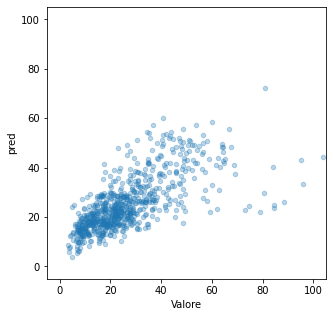

In [665]:
fig, ax = plt.subplots(figsize=(5, 5))
test_chart_data.plot.scatter("Valore", "pred", alpha=0.3, ax=ax)
# ax.set_xlim(-5, 165)
# ax.set_ylim(-5, 165)

ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)

In [666]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 7.91
Mean squared error: 148.84
Root mean squared error: 12.20


In [667]:
regressor.score(X_test, y_test)

0.45368197568679713

In [668]:
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R²:', r2)

R²: 0.45368197568679736


In [669]:
# importance

val = []
feat = []
importance = regressor.feature_importances_
for index, value in enumerate(importance):
    feat.append(f"{input_columns[index]}")
    val.append(value)

feat = [x for _, x in sorted(zip(val, feat), reverse=True)]
val = sorted(val, reverse=True)
for i in range(len(feat)):
    print(f"{feat[i]}: {val[i]}")


temp: 0.2968596378496002
w_sp: 0.26171631058531575
sol: 0.1094363890682024
press: 0.10929778309469376
w_dir: 0.09747699609250927
hum: 0.09509118305435404
rain: 0.03012170025532454


In [670]:
input_columns

['rain', 'temp', 'hum', 'w_dir', 'w_sp', 'press', 'sol']

In [719]:
prev_val = test_chart_data.iloc[-365].Valore
#predictions1 = [0] * 200
#predictions2 = [0] * 200

predictions1 = []
predictions2 = []

for i, row in test_chart_data.iloc[-365:].iterrows():
    row_array = row[input_columns].to_numpy()

    result1 = regressor.predict([row_array])[0]  # takes the predicted value


    row_array[1]+=6
    

    #row_array[-1] = prev_val
    result2 = regressor.predict([row_array])[0]  # takes the predicted value

        
    predictions1.append(result1)
    predictions2.append(result2)

c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegress

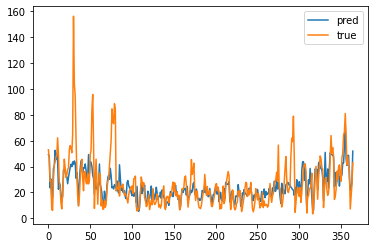

In [720]:
# NOT modified values

plt.plot(predictions1, label ="pred")
plt.plot(test_chart_data.iloc[-365:].Valore.to_numpy(), label="true")
plt.legend()
plt.show()

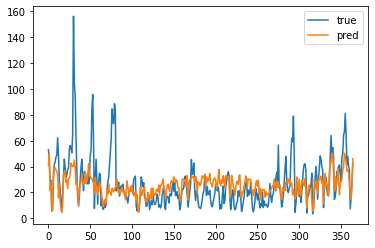

In [721]:
# Changed valeus

plt.plot(test_chart_data.iloc[-365:].Valore.to_numpy(), label="true")
plt.plot(predictions2, label ="pred")
plt.legend()
plt.show()

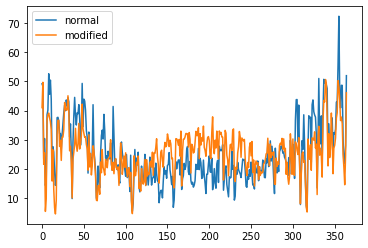

In [722]:
# Difference between real values and modified vales

plt.plot(predictions1, label="normal")
plt.plot(predictions2, label ="modified")
plt.legend()
plt.show()

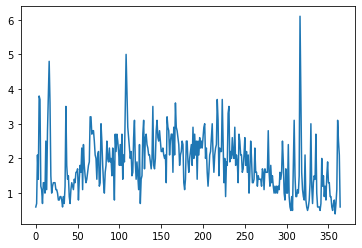

In [723]:
# Temperature plot

plt.plot(test_chart_data.iloc[-365:]["w_sp"].to_numpy())
plt.show()
